Pré-processamento e reconhecimento das etiquetas
===
---

### Objetivos
1. Reconhecimento da etiqueta
2. Leitura do código de barra
3. Reconhecimento dos caracteres da TAG

# Pré-processamento

Importando as bibliotecas

In [2]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

cv2.__version__

'4.8.0'

Carregando todas as imagem da pasta:

In [31]:
dir_path = '/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos'

files = os.listdir(dir_path)
images_list = []

for file in files:
    img_path = os.path.join(dir_path, file)
    print(img_path)
    source = cv2.imread(img_path)
    images_list.append(source)

/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172939.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_173217.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172655.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182238.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182432.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_181950.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172624.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_181942.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182001.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182251.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182003.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_182016.jpg
/home/nodyer/Área de Trabalho/TG Nodyer/TAG fotos/IMG_20230707_172558.jpg
/home/nodyer/Área de Trabalho/TG Nodye

Selecionando a imagem e redefinindo o seu tamanho:

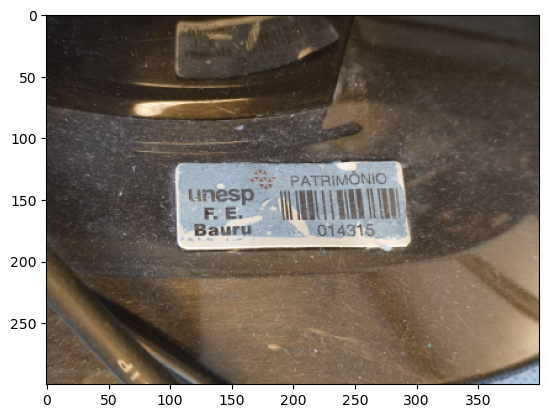

In [32]:
# Carrega a imagem
scr = images_list[1]

# Define a porcentagem de redimensionamento
percent = 10

# Calcula as novas dimensões da imagem
width = int(scr.shape[1] * percent / 100)
height = int(scr.shape[0] * percent / 100)

# Redimensiona a imagem
#scr = cv2.resize(scr, (width, height), interpolation = cv2.INTER_AREA)

#Exibe a imagem
plt.imshow(scr)
plt.show()

In [51]:
scr = cv2.rotate(scr, cv2.ROTATE_90_CLOCKWISE)

Alterando para grayscale:

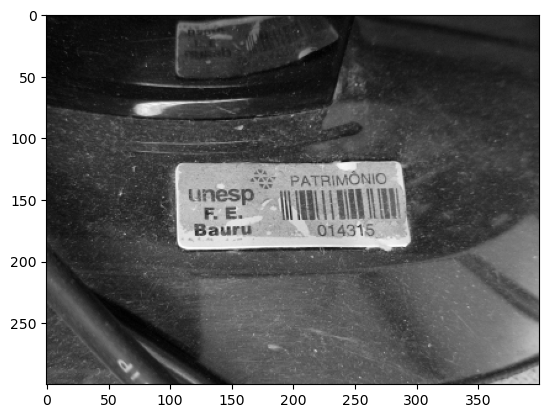

In [33]:
gray = cv2.cvtColor(scr, cv2.COLOR_BGR2GRAY)

#Exibe a imagem
plt.imshow(gray, 'gray')
plt.show()

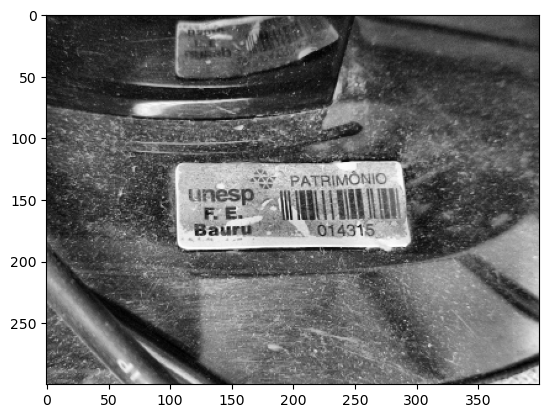

In [34]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl = clahe.apply(gray)
plt.imshow(cl, 'gray')
plt.show()

Aplicando Gaussian blur:

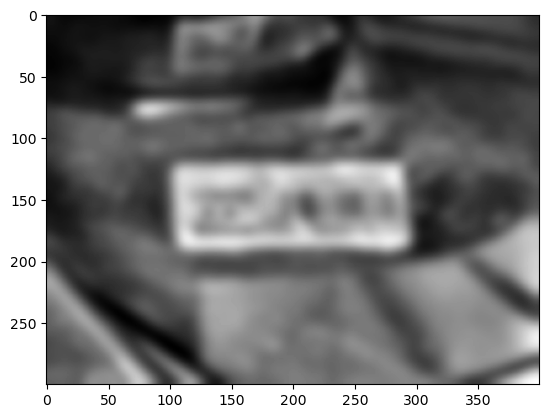

In [35]:
blur = cv2.GaussianBlur(cl, (31,31), 0)
plt.imshow(blur, 'gray')
plt.show()

Aplicando Threshold:

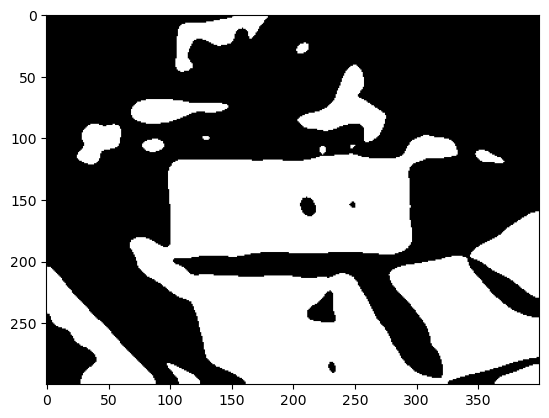

In [36]:
_, thresh = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#Exibe a imagem
plt.imshow(thresh, 'gray')
plt.show()

# Reconhecimento da etiqueta

A estratégia partirá da detecção de contorno e retangulos na imagem.

Contornos encontrados:  19


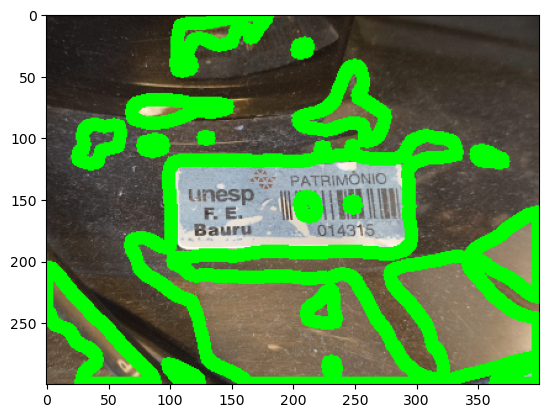

In [37]:
img_copy = np.copy(scr)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

print("Contornos encontrados: ", len(contours))

# Visualizando os contornos
cv2.drawContours(img_copy, contours, -1, (0, 255, 0), 10)

plt.imshow(img_copy)
plt.show()

Como essa estratégia pode encontrar inúmeros retangulos no imagem que não são de nosso interesse, será tomado a razão da altura e largura da etiqueta como referência para a condição de qual retangulo queremos encontrar.

In [42]:
razao_TAG = 4.6/1.8
print("Razão: ", razao_TAG)

Razão:  2.5555555555555554


Placas detectadas:  0


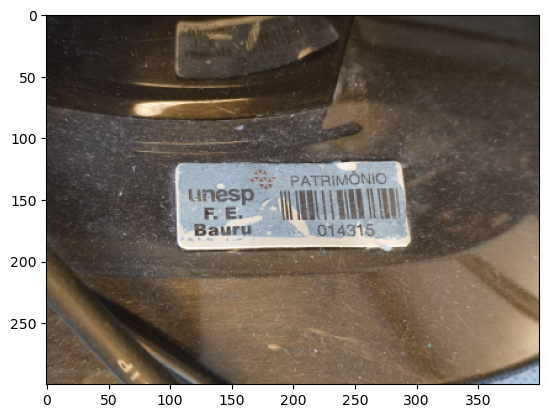

In [43]:
# Lista para armazenar regiões de interesse (ROIs)
roi_list = []

# Cria uma cópia da imagem de entrada
img_copy3 = np.copy(scr)

# Itera sobre os contornos encontrados na imagem
for c in contours:
    # Calcula o perímetro do contorno
    epsilon = cv2.arcLength(c, True)

    # Filtra contornos com perímetro maior que 6000
    if epsilon > 6000:
        # Aproxima o contorno para uma forma poligonal com base no parâmetro de precisão
        approx = cv2.approxPolyDP(c, 0.03 * epsilon, True)

        # Verifica se o contorno aproximado tem 4 vértices (retângulo)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(c)
            
            # Calcula a área do retângulo delimitado pelo contorno
            area = int(w) * int(h)
            print('Área: ', area)

            # Filtra regiões com área maior que 19000
            if area > 19000:
                # Calcula a razão de largura/altura do retângulo
                razao_cont = w/h
                print('Razão: ', razao_cont)

                # Verifica se a razão está dentro de uma faixa específica (com uma margem de 10%)
                if razao_cont >= (razao_TAG - 0.1 * razao_TAG) and razao_cont <= (razao_TAG + 0.1 * razao_TAG):
                    print('Conta1: ', razao_TAG - 0.1 * razao_TAG)
                    print('Conta2: ', razao_TAG + 0.1 * razao_TAG)
                    
                    # Desenha um retângulo ao redor da região de interesse na cópia da imagem
                    cv2.rectangle(img_copy3, (x, y), (x+w, y+h), (0, 255, 0), 10)
                    
                    # Adiciona o contorno à lista de ROIs
                    roi_list.append(c)

# Imprime o número de etiquetas detectadas
print('Placas detectadas: ', len(roi_list))

# Exibe a imagem com os retângulos desenhados
plt.imshow(img_copy3)
plt.show()

Por fim, será feito o recorte da imagem isolando a etiqueta no fundo, ou seja, uma região de interesse (ROI).

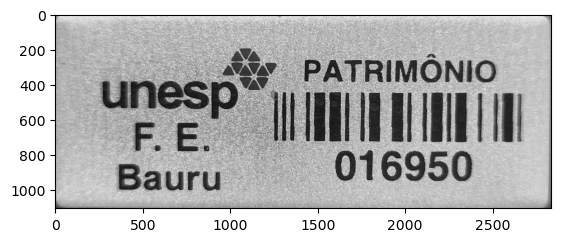

In [98]:
roi_cut_list = []

for item in roi_list:
    x,y,w,h = cv2.boundingRect(item)
    cut = cl[y+10:y+h-10,x+10:x+w-10]
    roi_cut_list.append(cut)

    #print(len(roi_list))
    #print(len(roi_cut_list))
    plt.subplot(1, len(roi_list), len(roi_cut_list))
    plt.imshow(cut, 'gray')

plt.show()

In [99]:
from pyzbar.pyzbar import decode

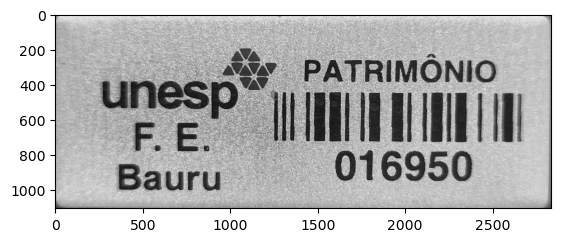

In [100]:
plt.imshow(cut, 'gray')
plt.show()

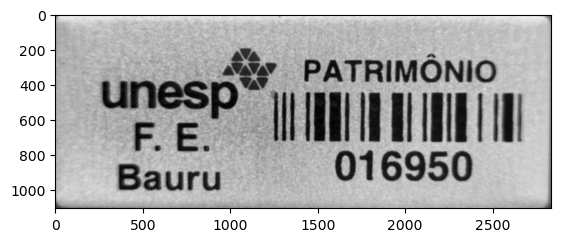

In [101]:
roi = cv2.GaussianBlur(cut, (21,21), 0)
plt.imshow(roi, 'gray')
plt.show()

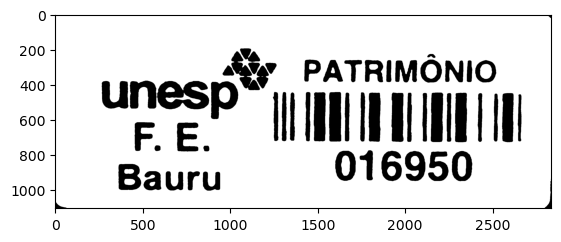

In [102]:
_, roi = cv2.threshold(roi,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_, roi2 = cv2.threshold(roi,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(roi, 'gray')
plt.show()

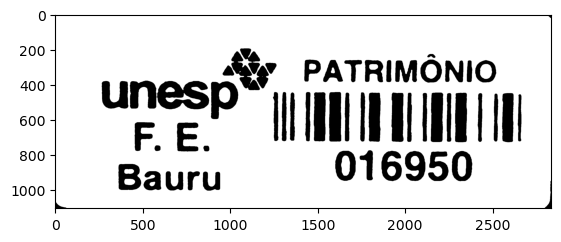

In [103]:
roi = cv2.medianBlur(roi,5,30)
plt.imshow(roi, 'gray')
plt.show()

In [104]:
for code in decode(roi):
    print(code.type)
    print(code.data.decode('utf-8'))

I25
016950


1246 458 1420 262


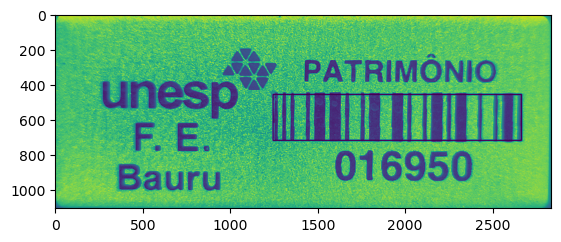

In [105]:
barcodes = decode(roi)
x, y, w, h = barcodes[0].rect
print(x,y,w,h)

draw_bar = np.copy(cut)
cv2.rectangle(draw_bar,(x,y),(x+w,y+h),(0,255,0), 7)

plt.imshow(draw_bar)
plt.show()

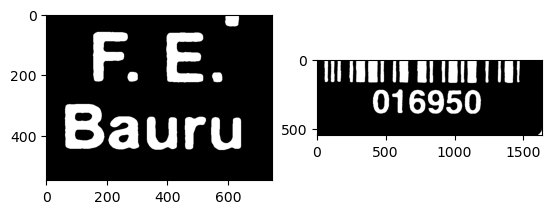

In [106]:
unidade = roi2[y+100:,300:x-200]
barra = roi2[y+100:,x-50:]

plt.subplot(1,2,1)
plt.imshow(unidade,'gray')
plt.subplot(1,2,2)
plt.imshow(barra, 'gray')
plt.show()

In [107]:
import pytesseract

config_char = r'-c tessedit_char_whitelist=AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz --psm 6 --oem 1'
config_num = r'-c tessedit_char_whitelist=0123456789 --psm 6 --oem 1'

chars = pytesseract.image_to_string(unidade, lang='por', config=config_char)
numbers = pytesseract.image_to_string(barra, lang='eng', config=config_num)

print('Caracteres detectados: ', chars)
print('Números detectados: ', numbers)

Caracteres detectados:  FE
Bauru

Números detectados:  016950

